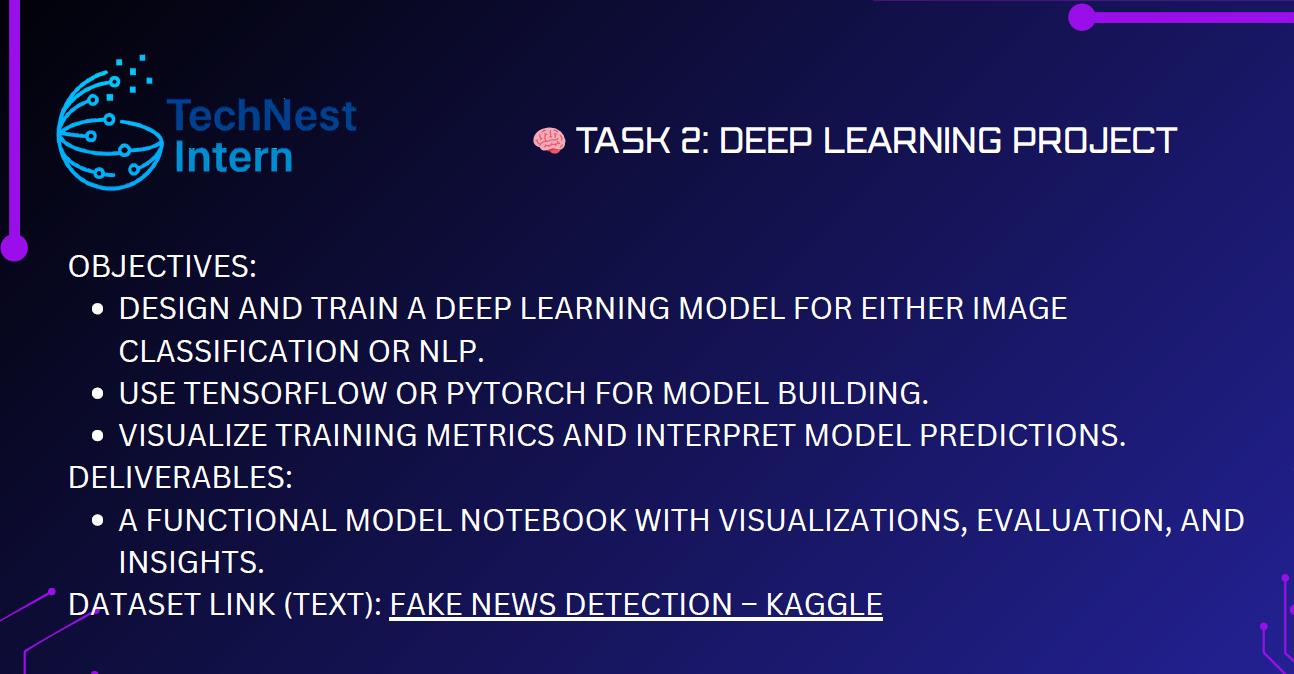

# **Using Kaggle Fake News Detection and building Deep Learning Model**

# Required Libraries

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow

import nltk
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer

# downloading nltk packages for NLP tasks

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading of Dataset

In [79]:
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

true_df['label'] = 1
fake_df['label'] = 0

# as we have 2 different files so concating it together
data = pd.concat([true_df,fake_df]).reset_index()

In [68]:
data.sample(8)

,index,title,text,subject,date,label
13279,13279,"Venezuela political talks end without deal, ne...",CARACAS (Reuters) - Members of Venezuela s gov...,worldnews,"December 3, 2017",1
4444,4444,Florida legislature poised to bolster 'Stand Y...,(Reuters) - Florida lawmakers advanced a measu...,politicsNews,"April 5, 2017",1
30512,9095,IT ONLY TOOK ONE TWEET FROM PRESIDENT TRUMP Fo...,A week after President Trump endorsed Ron DeSa...,politics,"Dec 29, 2017",0
31653,10236,Why Donald J. Trump Is The Only One Who Can De...,Every American should read and share this bril...,politics,"Aug 4, 2017",0
34797,13380,WHY HILLARY LOVES The Idea Of Barack Obama As ...,Remember when this would seem like a far-fetch...,politics,"Jul 31, 2016",0
23372,1955,Donald Trump ‘SHOCKED’ A Group Of Women Have ...,"For some reason, Donald Trump decided to speak...",News,"March 29, 2017",0
988,988,"U.S. State Department names Russian defense, i...",WASHINGTON (Reuters) - The U.S. State Departme...,politicsNews,"October 27, 2017",1
37874,16457,JUDGE JEANINE Tells Us What The Smoking Gun Is...,Judge Jeanine gives us facts on the relationsh...,Government News,"Aug 12, 2016",0


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    44898 non-null  int64 
 1   title    44898 non-null  object
 2   text     44898 non-null  object
 3   subject  44898 non-null  object
 4   date     44898 non-null  object
 5   label    44898 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


# EDA

# Fake and True News acc to Subjects

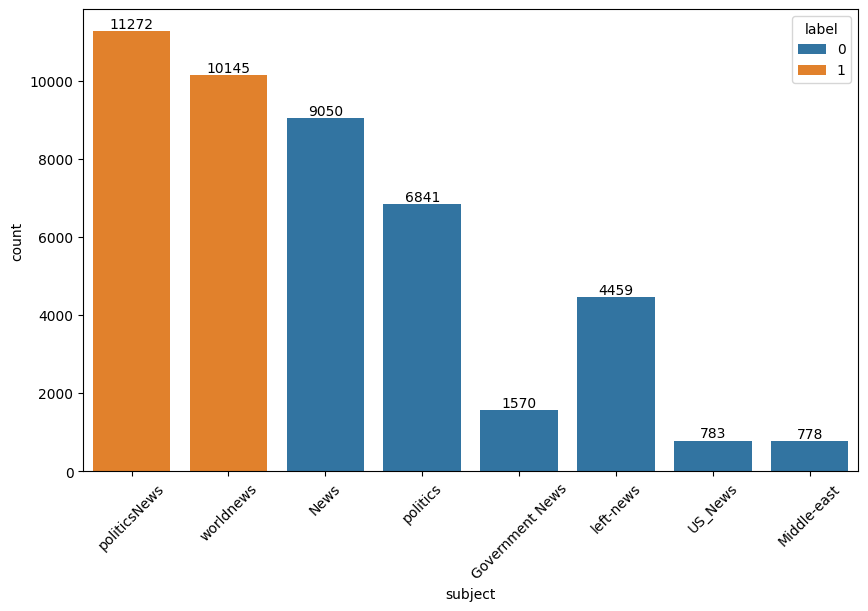

In [70]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data,x='subject', hue='label')
for i in ax.containers:
  plt.bar_label(i,)
plt.xticks(rotation=45)
plt.show()

# Counts of Fake and True News

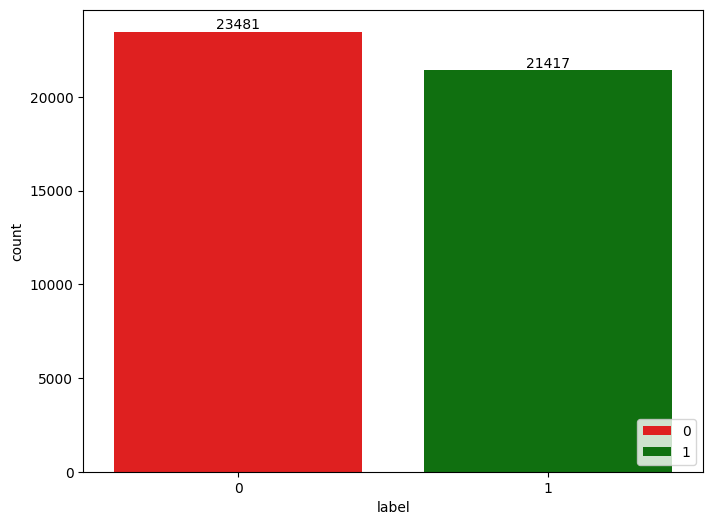

In [71]:
plt.figure(figsize=(8,6))
bx = sns.countplot(data,x='label',hue = 'label',palette=['red','green'])
for i in bx.containers:
  plt.bar_label(i,)
plt.legend(loc='lower right')
plt.show()

# TimeLine of Fake and True News

In [94]:
data['date'] = pd.to_datetime(data['date'],format="mixed",errors='coerce')

In [96]:
data.sample(5)

,index,title,text,subject,date,label
5643,5643,"U.S. moves to resume admitting refugees, inclu...",WASHINGTON (Reuters) - The U.S. State Departme...,politicsNews,2017-02-05,1
7603,7603,Appeals court revives challenge to Arizona vot...,(Reuters) - A U.S. appeals court on Wednesday ...,politicsNews,2016-11-02,1
40962,19545,DID HILLARY Just Lose Her “Get Out Of Jail Fre...,A senior Donald Trump adviser is calling Hilla...,left-news,2016-11-27,0
44492,23075,PROVOCATION? Republican Senators Introduce New...,21st Century Wire says Donald Trump s campaign...,Middle-east,2017-01-04,0
6475,6475,Mexico says rejects threats against investment...,MEXICO CITY (Reuters) - Mexico’s government sa...,politicsNews,2017-01-06,1


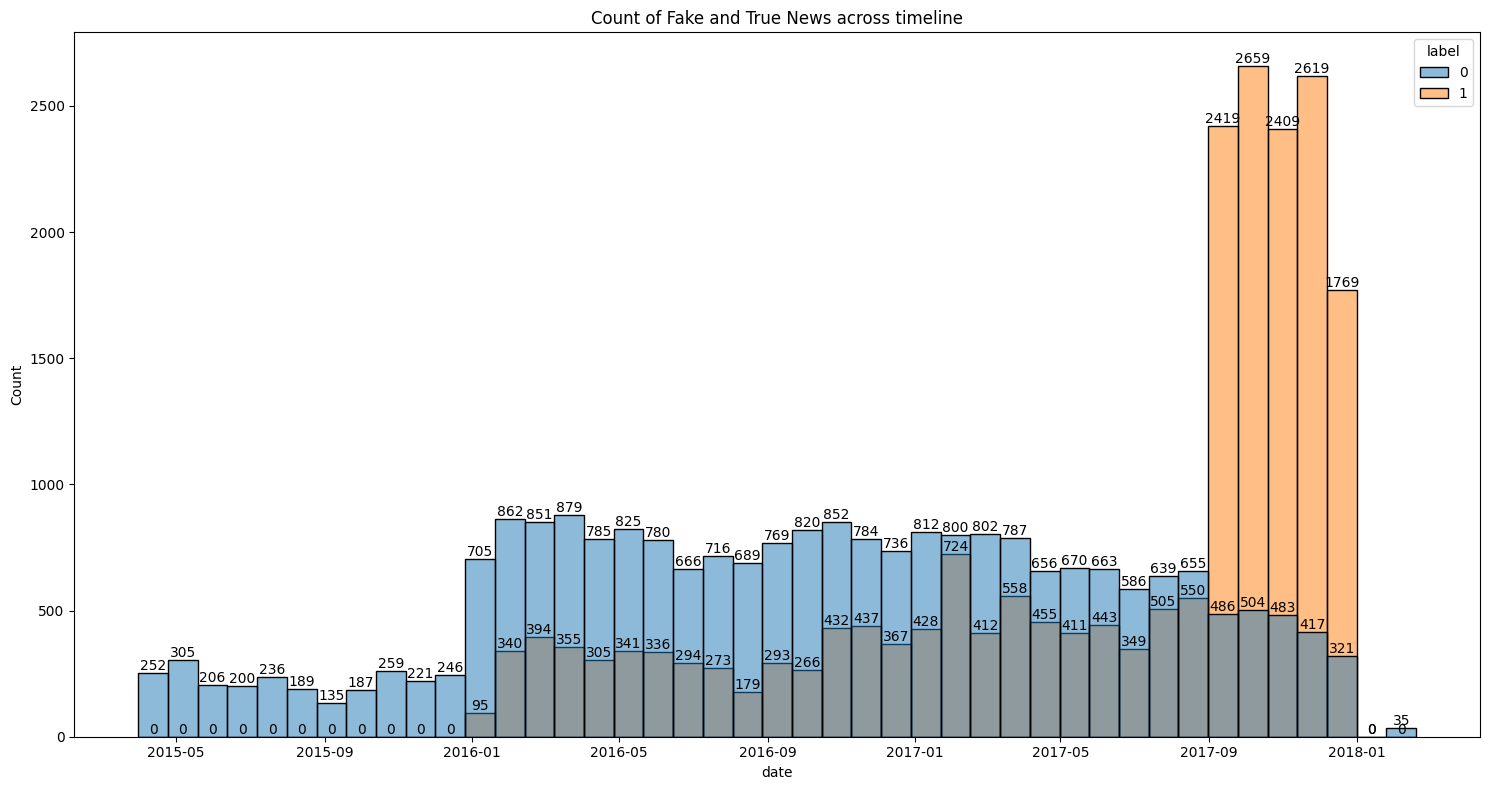

In [113]:
plt.figure(figsize=(15,8))
cx = sns.histplot(data,x='date',hue='label')
for i in cx.containers:
  plt.bar_label(i,)
plt.title("Count of Fake and True News across timeline")
plt.tight_layout()
plt.show()

# Shortening the text feature

In [7]:
data['text_1000'] = [data['text'][i][:1000] for i in range(0,len(data['text'])) ]

In [8]:
data.sample(5)

,index,title,text,subject,date,label,text_1000
37553,16136,IRS EXEC LOIS LERNER DEMANDS SECRECY In Law Su...,This is rich! Lois Lerner wants her testimony ...,Government News,"Apr 14, 2017",0,This is rich! Lois Lerner wants her testimony ...
22751,1334,Confused Old Man Forgets He’s At Arlington Ce...,Donald Trump showed up at Arlington National C...,News,"May 29, 2017",0,Donald Trump showed up at Arlington National C...
30706,9289,CONFUSED PROTESTERS Swarm Outside Trump NYC Fu...,The protesters in NYC must be confused They ye...,politics,"Dec 3, 2017",0,The protesters in NYC must be confused They ye...
13954,13954,'Wiping out' extremist ideology is my mission:...,PARIS (Reuters) - The head of a Saudi-based or...,worldnews,"November 24, 2017",1,PARIS (Reuters) - The head of a Saudi-based or...
35189,13772,DONALD TRUMP Gives Epic Response After PGA Mov...,One thing Donald Trump is really great at is d...,politics,"Jun 2, 2016",0,One thing Donald Trump is really great at is d...


# **TEXT PreProcessing**

# Tokenization

In [9]:
token_texts = []
for i,sentence in enumerate(data['text_1000']):
  tokens = re.sub('[^a-zA-Z]',' ',sentence)
  tokens = tokens.lower()
  tokens = tokens.split()
  token_texts.append(tokens)

In [10]:
print(token_texts[:2])

[['washington', 'reuters', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'u', 's', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'u', 's', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues', 'such', 'as', 'immigration', 'policy', 'even', 'as', 'the', 'nove

# Stemming (Lemmatization)

In [11]:
lemmatizer = WordNetLemmatizer()
stemmed_text = []
for i,tokens in enumerate(token_texts):
  stemming = [lemmatizer.lemmatize(i) for i in tokens]
  stemmed_text.append(stemming)

In [12]:
print(stemmed_text[:2])

[['washington', 'reuters', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'u', 's', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cut', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republican', 'u', 's', 'representative', 'mark', 'meadow', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmaker', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holiday', 'on', 'wednesday', 'lawmaker', 'will', 'begin', 'trying', 'to', 'pas', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issue', 'such', 'a', 'immigration', 'policy', 'even', 'a', 'the', 'november', 'co

# StopWords Removal

In [13]:
stopwords = set(stopwords.words('english'))
cleaned = []
for i,words in enumerate(stemmed_text):
  clean = [j for j in words if j not in stopwords]
  cleaned.append(clean)

In [14]:
print(cleaned[:2])

[['washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'u', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cut', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'way', 'among', 'republican', 'u', 'representative', 'mark', 'meadow', 'speaking', 'cbs', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmaker', 'bracing', 'battle', 'january', 'return', 'holiday', 'wednesday', 'lawmaker', 'begin', 'trying', 'pas', 'federal', 'budget', 'fight', 'likely', 'linked', 'issue', 'immigration', 'policy', 'even', 'november', 'congressional', 'election', 'campaign', 'approach', 'republican', 'seek', 'keep', 'control', 'congress', 'president', 'donald', 'trump', 'republican', 'want', 'big', 'budget', 'increase', 'military', 'spending', 'democrat', 'also', 'want', 'proportional', 'increase', 'non', 'defense', 'discretionary', 'spending', 'program', 'support', 'educat

# Creating Encoding for text using Tokenizer

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned)
sequences = tokenizer.texts_to_sequences(cleaned)

In [16]:
print(sequences[:2])

[[18, 7, 229, 127, 11, 3120, 5, 125, 597, 72, 1041, 3327, 56, 930, 393, 93, 360, 89, 1176, 127, 137, 900, 398, 6648, 1721, 2915, 7927, 95, 302, 11, 5, 194, 695, 6900, 394, 1537, 254, 98, 1856, 457, 388, 103, 693, 225, 12410, 1008, 527, 531, 1966, 48, 225, 894, 300, 780, 103, 398, 431, 307, 1718, 147, 303, 117, 61, 467, 486, 21, 33, 1473, 11, 775, 309, 258, 125, 6, 9, 1, 11, 81, 316, 398, 853, 104, 693, 55, 35, 81, 9929, 853, 745, 272, 13116, 693, 193, 97, 28041], [18, 7, 1226, 14, 767, 39, 22, 9248, 5, 104, 1302, 64, 969, 103, 54, 1335, 2, 58, 6, 9, 1, 75, 462, 715, 438, 1556, 1226, 379, 29, 103, 715, 54, 13, 18, 13, 885, 36, 37, 1337, 75, 568, 179, 448, 152, 873, 54, 231, 3121, 104, 894, 3499, 1226, 5993, 1137, 177, 105, 40, 2, 75, 895, 438, 105, 272, 4, 323, 3301, 971, 1465, 147, 496, 37, 719, 28042, 4456, 715, 11492, 75, 4, 462, 1650, 10543, 1465, 483, 1125, 6, 5839, 297, 509, 54, 8416, 40, 2, 394, 831]]


# Word_Index to find the input_dim

In [17]:
input_dimension = len(tokenizer.word_index)+1
input_dimension

63680

# Padding Width

In [18]:
length_sequences = []
for i,sequence in enumerate(sequences):
     length = len(sequence)
     length_sequences.append(length)

In [19]:
padding_width = max(length_sequences)
padding_width

156

# Converting according to padding width

In [20]:
sequences_pad = pad_sequences(sequences, maxlen=padding_width)
print(sequences_pad[:2])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0    18     7   229   127    11  3120     5   125   597    72  1041
   3327    56   930   393    93   360    89  1176   127   137   900   398
   6648  1721  2915  7927    95   302    11     5   194   695  6900   394
   1537   254    98  1856   457   388   103   693   225 12410  1008   527
    531  1966    48   225   894   300   780   103   398   431   307  1718
    147   303   117    61   467   486    21    33  1473    11   775   309
    258   125     6     9     1    11    81   316   398   853   104   693
     55    35    81  9929   853   745   272 13116   693   193    97 28041]
 [    0     0     0     0     0     0

# Splitting into Features and Labels

In [21]:
x = sequences_pad
y = data['label']

print(f"Shape of Features :  {x.shape}")
print(f"Shape of Labels : {y.shape}")

Shape of Features :  (44898, 156)
Shape of Labels : (44898,)


# Splitting into training and testing set

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)

print(f" Shape of training set : {x_train.shape}")
print(f" Shape of training labels : {y_train.shape}")
print(f" Shape of testing set : {x_test.shape}")
print(f" Shape of testing labels : {y_test.shape}")

 Shape of training set : (35918, 156)
 Shape of training labels : (35918,)
 Shape of testing set : (8980, 156)
 Shape of testing labels : (8980,)


# Model Building

In [23]:
model = Sequential()
model.add(layers.Embedding(input_dim=input_dimension, output_dim=32))
model.add(layers.SpatialDropout1D(rate=0.40))
model.add(layers.LSTM(64))
model.add(layers.Dense(1,activation='sigmoid'))

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Model Fitting/Training

In [25]:
history = model.fit(x_train,y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8586 - loss: 0.3191 - val_accuracy: 0.9919 - val_loss: 0.0481
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9856 - loss: 0.0711 - val_accuracy: 0.9975 - val_loss: 0.0180
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9828 - loss: 0.0767 - val_accuracy: 0.9964 - val_loss: 0.0212
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9307 - loss: 0.1878 - val_accuracy: 0.9908 - val_loss: 0.0472
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8826 - loss: 0.2731 - val_accuracy: 0.9923 - val_loss: 0.0398
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9925 - loss: 0.0324 - val_accuracy: 0.9948 - val_loss: 0.0303
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9940 - loss: 0.0279 - val_accuracy: 0.9955 - val_loss: 0.0240
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9949 - loss: 0.0226 - 

# Model parameters

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 156, 32)        │     2,037,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 156, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,187,973 (23.61 MB)

 Trainable params: 2,062,657 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,125,316 (15.74 MB)

# Loss, Accuracy Vs Validation Loss, Validation Accuracy

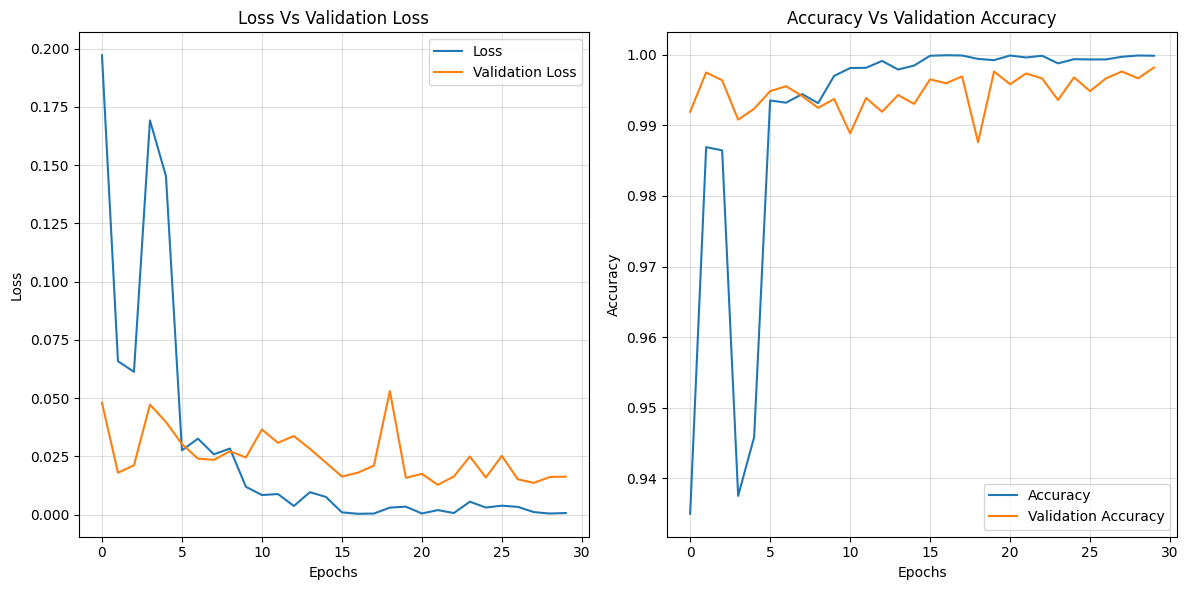

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.title("Loss Vs Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha = 0.40)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label ='Validation Accuracy')
plt.title("Accuracy Vs Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(alpha = 0.40)
plt.tight_layout()
plt.show()

# Model Evaluation

In [30]:
loss, accuracy = model.evaluate(x_test,y_test)
print(f"Loss : {loss:.4f}\n\nAccuracy : {accuracy:.4f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9975 - loss: 0.0210
Loss : 0.0189

Accuracy : 0.9978


**Model Predictions**

In [31]:
y_pred = model.predict(x_test.reshape(-1,156).astype('float'))
predicted_labels = [1 if i>0.50 else 0 for i in y_pred]

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# Confusion Matrix of Predicted Labels by Model

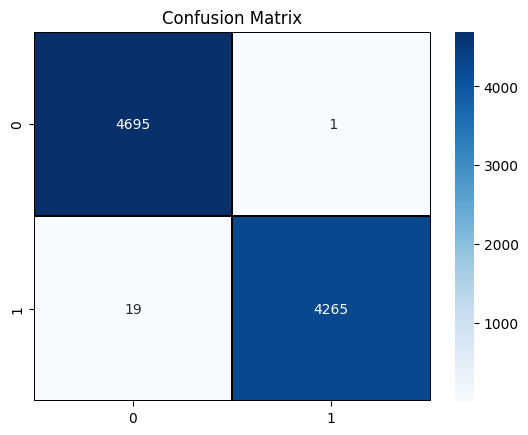

In [41]:
cm = confusion_matrix(y_test,predicted_labels)
sns.heatmap(cm,cmap='Blues',annot=True,fmt='2g',linewidths=0.20,linecolor='black')
plt.title("Confusion Matrix")
plt.show()

# Classification Report

In [43]:
print("Classification Report .........................\n\n")
print(classification_report(y_test,predicted_labels))

Classification Report .........................


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



# Predictions on Unseen Data

In [33]:
y_test = y_test.reset_index(drop=True)

**Function that give labels on x_test**

In [34]:
def predict(x_test,y_test):
   pred = model.predict(x_test.reshape(-1,padding_width).astype('float'))
   pred = pred[0][0]
   label = 0
   if pred>0.50:
    label = 1
    print(f"\nLabel : {label} (News is True) score : {pred:.4f}")
   else:
    print(f"\nLabel : {label} (News is Fake) score : {pred:.4f}")

   print(f"\nAcutal Label : {y_test} , Predicted Label : {label}")


In [35]:
predict(x_test[150],y_test[150])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Label : 1 (News is True) score : 0.9998

Acutal Label : 1 , Predicted Label : 1


In [36]:
predict(x_test[1000],y_test[1000])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Label : 0 (News is Fake) score : 0.0000

Acutal Label : 0 , Predicted Label : 0
